In [226]:
import pandas as pd 

df_raw = pd.read_json('C:\\Users\\ctcas\\Documents\\SoftwareMEProgram\\611_machinelearning_ENSF\\project\\ENSF611-FinPrediction\\data\\aapl_price.json')

df_raw.describe


<bound method NDFrame.describe of            c        h        l        n        o                     t  \
0      23.78   23.780   23.020   351452   23.160  2016-01-04T05:00:00Z   
1      23.18   23.890   23.110   321365   23.870  2016-01-05T05:00:00Z   
2      22.73   23.100   22.540   409164   22.690  2016-01-06T05:00:00Z   
3      21.77   22.600   21.760   462836   22.270  2016-01-07T05:00:00Z   
4      21.88   22.370   21.840   419555   22.240  2016-01-08T05:00:00Z   
...      ...      ...      ...      ...      ...                   ...   
2471  271.40  274.140  268.480   984732  271.990  2025-10-30T04:00:00Z   
2472  270.37  277.320  269.160  1013846  276.990  2025-10-31T04:00:00Z   
2473  269.05  270.850  266.250   731851  270.420  2025-11-03T05:00:00Z   
2474  270.04  271.486  267.615   713303  268.325  2025-11-04T05:00:00Z   
2475  270.14  271.700  266.930   588621  268.610  2025-11-05T05:00:00Z   

              v          vw  
0     287741356   23.470000  
1     234762144  

In [227]:
# RSI calculation method found on: https://rbdundas.medium.com/calculate-relative-strength-index-rsi-and-chart-with-candles-using-python-pandas-and-matplotlib-f58d926249ac

# Get gain/loss as defined by RSI calculation 
df = df_raw

df.at[:,'gain'] = 0.0
df.at[:,'loss'] = 0.0
for i in range(1,len(df)):
    if df.at[i,'c'] >= df.iloc[i-1]['c']:
        df.at[i,'gain'] = (df.iloc[i]['c'] - df.iloc[i-1]['c'])
        df.at[i,'loss'] = 0.0
    elif df.at[i,'c'] < df.iloc[i-1]['c']:
        df.at[i,'gain'] = 0.0
        df.at[i,'loss'] = (df.iloc[i-1]['c'] - df.iloc[i]['c'])

# Get average gain and loss over some period 
period = 14 # Standard value apparently 
df.at[:,'avg_gain'] = 0.0
df.at[:,'avg_loss'] = 0.0
fpgavg = df.iloc[:period-1]['gain'].mean()
fplavg = df.iloc[:period-1]['loss'].mean()
df.at[period-1,'avg_gain'] = fpgavg
df.at[period-1,'avg_loss'] = fplavg

for i in range(period,len(df)):
    df.at[i,'avg_gain'] = (df.iloc[i-1]['avg_gain']*(period-1)+df.iloc[i]['gain'])/period 
    df.at[i,'avg_loss'] = (df.iloc[i-1]['avg_loss']*(period-1)+df.iloc[i]['loss'])/period 

# Find RSI 
df.at[:,'RSI'] = 0.0 
for i in range(period-1,len(df)):
    df.at[i,'RSI'] = 100-(100/(1+df.iloc[i]['avg_gain']/df.iloc[i]['avg_loss']))


In [228]:
from datetime import datetime
format_string = "%Y-%m-%d"

for i in range(len(df)):
    c_date = datetime.strptime(df.iloc[i]['t'].split('T')[0],format_string).date()
    df.at[i,'year'] = c_date.year
    df.at[i,'month'] = c_date.month
    df.at[i,'day_of_month'] = c_date.day
    df.at[i,'day'] = c_date.weekday() 


In [229]:
from sklearn.model_selection import train_test_split
drop_columns = ['c','h','l','n','o','v','vw','loss','gain','t']
#drop_columns = ['c','t']
# Set up for linear regression 
X = df.drop(drop_columns,axis=1)
# Set up the target as the NEXT day's close 
for i in range(len(X)-1):
    y.at[i] = df.iloc[i+1]['c']
X = X.drop(index=len(X)-1)
y = y.drop(index=len(X)-1)
print(len(X))
print(len(y))
prediction_range = 200
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train = X.iloc[:-prediction_range]
X_test = X.iloc[len(X_train):]
y_train = y.iloc[:-prediction_range]
y_test = y.iloc[len(X_train):]

2475
2475


In [230]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_validate 
from sklearn.metrics import r2_score

model = LinearRegression() 
model.fit(X_train,y_train)
result = cross_validate(model,X_train,y_train,cv = 5, scoring='r2',return_train_score=True,return_estimator=True)
print(result['train_score'].mean()," ",result['test_score'].mean())

y_predict = model.predict(X_test) 
print(r2_score(y_test,y_predict))

0.9357771548460606   -12.155217015093731
0.3166213280753788


In [231]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)

model.fit(X_train,y_train)
result = cross_validate(model,X_train,y_train,cv = 5, scoring='r2',return_train_score=True,return_estimator=True)
print(result['train_score'].mean()," ",result['test_score'].mean())

y_predict = model.predict(X_test) 
print(r2_score(y_test,y_predict))

0.9997550279082563   -3.1915073940650696
-0.02175111681671793


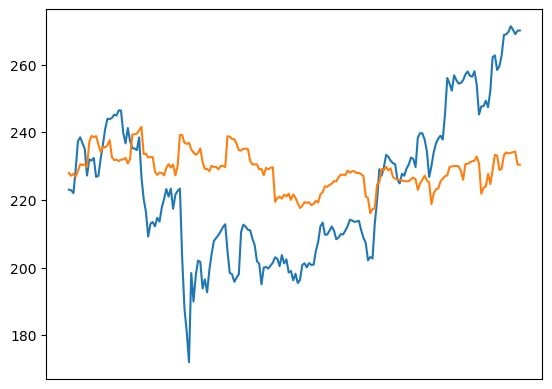

In [232]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
#ax.plot(df.iloc[:-prediction_range]['t'],y_train)
ax.plot(list(range(len(X_test))),y_test)
ax.plot(list(range(len(X_test))),y_predict)
ax.xaxis.set_visible(False) 

plt.show()

